In [1]:
import os
import shutil
from PIL import Image
import numpy as np
import hashlib

# Original (read-only)
INPUT_TRAIN_PATH = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"
INPUT_TEST_PATH  = "/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test"

# Working (writable)
WORKING_DIR = "/kaggle/working/deepfake_cleaned"
TRAIN_PATH = os.path.join(WORKING_DIR, "train")
TEST_PATH  = os.path.join(WORKING_DIR, "test")

CLASSES = ["real", "fake"]
def copy_dataset(src, dst):
    """
    Copies dataset from read-only input to writable working directory.
    """
    if not os.path.exists(dst):
        shutil.copytree(src, dst)
        print(f"✔ Dataset copied from {src} to {dst}")
    else:
        print(f"✔ Dataset already exists at {dst}")

copy_dataset(INPUT_TRAIN_PATH, TRAIN_PATH)
copy_dataset(INPUT_TEST_PATH, TEST_PATH)
def remove_corrupted_images(dataset_path):
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1

    print(f"✔ Removed {removed} corrupted images from {dataset_path}")
def remove_exact_duplicates(dataset_path):
    hashes = {}
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            with open(file_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in hashes:
                os.remove(file_path)
                removed += 1
            else:
                hashes[file_hash] = file_path

    print(f"✔ Removed {removed} duplicate images from {dataset_path}")
def remove_corrupted_images(dataset_path):
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1

    print(f"✔ Removed {removed} corrupted images from {dataset_path}")
def normalize_image(image_array):
    return image_array.astype(np.float32) / 255.0
remove_corrupted_images(TRAIN_PATH)
remove_corrupted_images(TEST_PATH)

remove_exact_duplicates(TRAIN_PATH)
remove_exact_duplicates(TEST_PATH)


✔ Dataset copied from /kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train to /kaggle/working/deepfake_cleaned/train
✔ Dataset copied from /kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test to /kaggle/working/deepfake_cleaned/test
✔ Removed 0 corrupted images from /kaggle/working/deepfake_cleaned/train
✔ Removed 0 corrupted images from /kaggle/working/deepfake_cleaned/test
✔ Removed 3 duplicate images from /kaggle/working/deepfake_cleaned/train
✔ Removed 1 duplicate images from /kaggle/working/deepfake_cleaned/test


In [2]:
import os

TRAIN_PATH = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"

classes = [
    d for d in os.listdir(TRAIN_PATH)
    if os.path.isdir(os.path.join(TRAIN_PATH, d))
]

print("Detected classes:", classes)


Detected classes: ['fake', 'real']


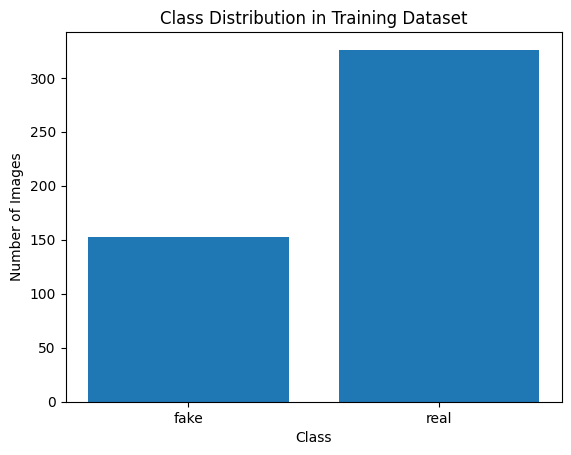

In [3]:
import matplotlib.pyplot as plt

counts = []
for label in classes:
    class_path = os.path.join(TRAIN_PATH, label)
    counts.append(len(os.listdir(class_path)))

plt.figure()
plt.bar(classes, counts)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


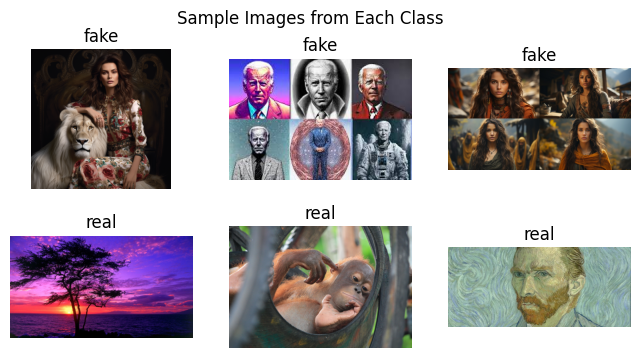

In [4]:
import random
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
idx = 1

for label in classes:
    folder = os.path.join(TRAIN_PATH, label)
    samples = random.sample(os.listdir(folder), 3)

    for img_name in samples:
        img = Image.open(os.path.join(folder, img_name))
        plt.subplot(len(classes), 3, idx)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
        idx += 1

plt.suptitle("Sample Images from Each Class")
plt.show()


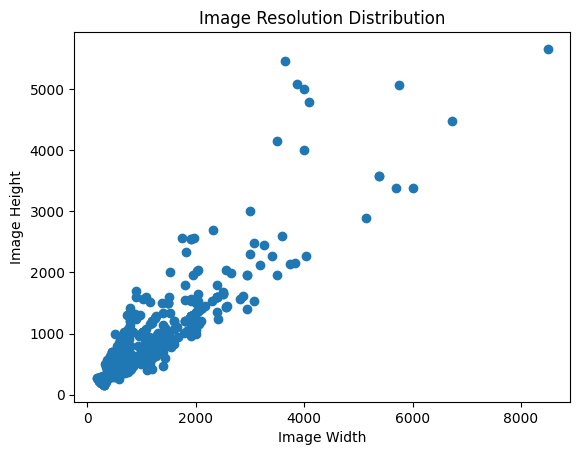

In [5]:
widths, heights = [], []

for label in classes:
    folder = os.path.join(TRAIN_PATH, label)
    for img_name in os.listdir(folder):
        img = Image.open(os.path.join(folder, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure()
plt.scatter(widths, heights)
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Image Resolution Distribution")
plt.show()
